# Conditional independence testing for deterministic extraneous latents

# Import

In [ ]:
import copy
import os

In [56]:
import joblib

In [57]:
import re

In [58]:
import torch
import numpy as np

In [59]:
import matplotlib.pyplot as plt

In [60]:
from scipy.stats import multivariate_normal

In [61]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [62]:
import seaborn as sns

In [63]:
torch.cuda.is_available()

True

In [64]:
torch.__version__

'2.4.0+cu121'

In [65]:
import sys

In [ ]:
import GPUtil

if torch.cuda.is_available():

    available_gpus = GPUtil.getAvailable(order='memory', limit=1)

    if available_gpus:
        selected_gpu = available_gpus[0]

        device = torch.device(f"cuda:{selected_gpu}")

        print(f"Using GPU: {selected_gpu} with the lowest memory usage.")
    else:
        print("No GPUs available with low memory usage.")
else:
    device = torch.device("cpu")

print(device)

In [ ]:

torch.manual_seed(42);

In [ ]:
sys.path.append("./src/DistributionalPrincipalAutoencoder")
sys.path.append("./src/engression")
sys.path.append("./src/mlcolvar")
sys.path.append("./src/PyTorch-VAE")

In [ ]:
sys.path.append("src/DistributionalPrincipalAutoencoder")
sys.path.append("src/engression")
sys.path.append("src/mlcolvar")
sys.path.append("src/PyTorch-VAE")

In [73]:
from dpa.dpa_fit import DPA

In [ ]:

from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics, plot_gradient_2D, \
    plot_streamlines_2D, plot_level_center_vectors_2D

In [ ]:
import math

In [76]:
from scipy.stats import kstest

In [77]:
use_threads = 20

In [ ]:
def slurm_cpus():
    for var in ("SLURM_CPUS_PER_TASK", "SLURM_CPUS_ON_NODE"):
        if var in os.environ:
            return int(os.environ[var])

    try:
        import psutil
        return len(psutil.Process().cpu_affinity())
    except Exception:
        return None


n_threads = slurm_cpus() or 1
print(f"Nthreads {n_threads}")
n_threads = min(n_threads, use_threads)
print("Use", n_threads, "threads")

os.environ["OMP_NUM_THREADS"] = f"{n_threads}"
os.environ["MKL_NUM_THREADS"] = f"{n_threads}"
os.environ["OPENBLAS_NUM_THREADS"] = f"{n_threads}"
torch.set_num_threads(n_threads)

In [ ]:
import numpy as np
import torch
import scipy
from scipy import stats

# Plot setup

**TODO: disable this when plotting for the paper!**

In [ ]:
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['axes.facecolor'] = 'white'

# Boilerplate Code

In [ ]:

def extract_first_numbers_after_epoch(filename):
    with open(filename, 'r') as file:
        text = file.read()

    pattern = r'\[Epoch (\d+)\]\s+([-*\d.]+)'
    matches = re.findall(pattern, text)
    numbers = np.array([(float(m1), float(m2)) for m1, m2 in matches])
    return numbers

In [ ]:
class EncoderModule(torch.nn.Module):
    def __init__(self, trained_model, standardize=False, x_mean=None, x_std=None):
        super(EncoderModule, self).__init__()
        self.trained_model = trained_model
        self.trained_model.raw = trained_model.model
        self.encoder = self.trained_model.model.encoder
        if standardize is None:
            self.standardize = self.trained_model.standardize
        else:
            self.standardize = standardize
        if x_mean is None:
            self.x_mean = self.trained_model.x_mean
        else:
            self.x_mean = x_mean
        if x_std is None:
            self.x_std = self.trained_model.x_std
        else:
            self.x_std = x_std

        self.device = next(self.encoder.parameters()).device

    def forward(self, x, k=None, mean=True, gen_sample_size=100):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        x = x.to(self.device)

        if not x.requires_grad:
            x.requires_grad_(True)

        if self.standardize:
            x = (x - self.x_mean.to(self.device)) / self.x_std.to(self.device)

        if k is None:
            k = self.trained_model.latent_dim
        if self.trained_model.encoder_k:
            x = self.trained_model.get_k_embedding(k, x)

        z = self.encoder(x)

        return z[:, :k]

In [ ]:
def plot_3d(points, points_color=None, title=None, save_dir=None):
    x, y, z = points.T
    fig, ax = plt.subplots(
        figsize=(5, 5),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    if title is not None:
        fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    if save_dir is not None:
        plt.savefig(save_dir, bbox_inches='tight')
    plt.show()

# Data generating code

In [ ]:
def make_linear_line(n=3_000, noise_std=0.1):
    z = np.random.randn(n, 1)
    eps = noise_std * np.random.randn(n, 1)
    X = np.concatenate([z, eps], axis=1)

    return X.astype(np.float32)


def parabola(n=2000):
    t = np.random.uniform(-1, 1, n)[:, None]
    return np.hstack([t, t ** 2])


def exponential(n=2000):
    t = np.random.uniform(-3, 3, n)[:, None]
    return np.hstack((t, np.exp(t)))


def helix_slice(n=2000):
    t = np.random.uniform(0, 4 * np.pi, n)[:, None]
    return np.hstack((t, np.cos(t)))


def grid_sum(n_side=60):
    s = np.linspace(-1, 1, n_side)
    xx, yy = np.meshgrid(s, s)
    Z = np.column_stack([xx.ravel(), yy.ravel()])
    U = Z.sum(axis=1, keepdims=True)
    return np.hstack((Z, U))


GENS = dict(parabola=parabola,
            exponential=exponential,
            helix_slice=helix_slice,
            grid_sum=grid_sum)

## Determinism code

In [96]:
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer

In [ ]:


from npeet import entropy_estimators as ee
from sklearn.neighbors import NearestNeighbors
from skdim.id import TwoNN
from skdim import id as skid

In [ ]:


def _fit_model(Z, U, model, **kwargs):
    """
    Internal helper: fit chosen model type and return predictions.
    Currently supported:
        'poly'   : polynomial up to degree d (default d=8)
        'spline' : cubic spline with n_knots (default 15)
        'rf'     : Random‑Forest (robust non‑parametric baseline)
    """
    if model == 'poly':
        deg = kwargs.get('degree', 12)
        scaler = StandardScaler()
        Zs = scaler.fit_transform(Z)

        Zb = PolynomialFeatures(degree=deg, include_bias=True).fit_transform(Zs)
        y_pred = LinearRegression().fit(Zb, U).predict(Zb)

    elif model == 'spline':
        deg = kwargs.get('degree', 3)
        n_knots = kwargs.get('n_knots', 15)
        Zb = SplineTransformer(degree=deg, n_knots=n_knots).fit_transform(Z)
        y_pred = LinearRegression().fit(Zb, U).predict(Zb)

    elif model == 'rf':
        from sklearn.ensemble import RandomForestRegressor
        scaler = StandardScaler()
        Zs = scaler.fit_transform(Z)

        n_estimators = kwargs.get('n_estimators', 400)
        min_samples_leaf = kwargs.get('min_samples_leaf', 2)

        est = RandomForestRegressor(
            n_estimators=n_estimators,
            min_samples_leaf=min_samples_leaf,
            random_state=0, n_jobs=-1
        ).fit(Zs, U.ravel())
        y_pred = est.predict(Z)[:, None]

    else:
        raise ValueError(f"Unknown model type '{model}'")
    return y_pred


def determinism_check(Z, U, model='spline',
                      r2_threshold=0.999, maxerr_threshold=1e-2, **kwargs):
    """
    General‑purpose *vacuous CI* checker.

    Parameters
    ----------
    Z : ndarray (n, d_z)
    U : ndarray (n, d_u)
    model : str
        'spline' (default), 'poly', or 'rf'
    r2_threshold : float
        Pass if R² ≥ threshold.
    maxerr_threshold : float
        Pass if max |U - g(Z)| ≤ threshold.
    kwargs : keyword args forwarded to _fit_model
        • spline: degree=3, n_knots=15
        • poly  : degree=12
        • rf    : any Random‑Forest parameters

    Returns
    -------
    dict with keys {max_err, mean_err, R2, passed}
    """
    y_pred = _fit_model(Z, U, model, **kwargs)
    resid = np.abs(U - y_pred)
    max_err = resid.max()
    mean_err = resid.mean()
    R2 = r2_score(U, y_pred)
    passed = (R2 >= r2_threshold) and (max_err <= maxerr_threshold)

    return dict(max_err=max_err, mean_err=mean_err, R2=R2, passed=passed)


In [ ]:
def conditional_entropy(U, Z, k=5):
    """
    k‑NN Kozachenko–Leonenko estimator:
        H(U|Z) = H(U,Z) - H(Z).
    U, Z must be 2‑D arrays  (n, d_u)  (n, d_z)
    Returns entropy in nats.
    """
    joint = np.hstack([U, Z])
    h_joint = ee.entropy(joint, k=k)
    h_z = ee.entropy(Z, k=k)
    return h_joint - h_z


def estimate_id(X, estimator='TwoNN', **kwargs):
    """
    Estimate intrinsic dimension of point cloud X (n, d).
    Supports d >= 1.
    """
    if X.shape[1] == 1:

        if estimator == 'fixed':
            return 1.0

        elif estimator == 'MLE':

            X = np.repeat(X, 2, axis=1)

        elif estimator == 'TwoNN':
            X = np.repeat(X, 2, axis=1)
        else:
            raise ValueError("Unknown estimator for 1‑D input.")

    if estimator == 'TwoNN':
        return skid.TwoNN(**kwargs).fit(X).dimension_
    elif estimator == 'MLE':
        return skid.MLE(**kwargs).fit(X).dimension_
    else:
        raise ValueError(f"Unsupported estimator '{estimator}'.")


def intrinsic_dim_drop(Z, U, estimator='TwoNN', **kwargs):
    """
    Returns intrinsic dimensions of Z and (Z,U) and their difference.
    Works for any input dimension >= 1.
    """
    id_Z = estimate_id(Z, estimator=estimator, **kwargs)
    id_ZU = estimate_id(np.hstack([Z, U]),
                        estimator=estimator,
                        **kwargs)
    return {'id_Z': id_Z, 'id_ZU': id_ZU, 'drop': id_ZU - id_Z}


def bootstrap_dim_drop(Z, U, n_boot=200, k=15, eps=1e-10, estimator="MLE"):
    Z_dup = np.hstack([Z, Z])

    drops = []

    n = len(Z)
    for _ in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        Zb = Z_dup[idx] + eps * np.random.randn(*Z_dup[idx].shape)
        Ub = U[idx] + eps * np.random.randn(*U[idx].shape)

        id_Z = estimate_id(Zb, estimator=estimator)

        id_ZU = estimate_id(np.hstack([Zb, Ub]), estimator=estimator)
        drops.append(id_ZU - id_Z)

    return np.percentile(drops, [2.5, 50, 97.5]), np.array(drops)


def bootstrap_dim_drop_bak(Z, U, n_boot=200, k=15, eps=1e-10):
    Z_dup = np.hstack([Z, Z])
    est = skid.MLE(K=k)
    drops = []

    n = len(Z)
    for _ in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        Zb = Z_dup[idx] + eps * np.random.randn(*Z_dup[idx].shape)
        Ub = U[idx] + eps * np.random.randn(*U[idx].shape)

        id_Z = est.fit(Zb).dimension_
        id_ZU = est.fit(np.hstack([Zb, Ub])).dimension_
        drops.append(id_ZU - id_Z)

    return np.percentile(drops, [2.5, 50, 97.5]), np.array(drops)


# Gaussian line

## The model

In [100]:
n_feats = 2
k = 2
num_layer = 4
hidden_dim = 100
latent_dims = list(range(k + 1))[::-1]


In [101]:
prefix = f"res/indep/gauss_line/{k}k{num_layer}l{hidden_dim}h/"

In [ ]:
dpaModel_line = DPA(beta=1.,
                    dist_enc="deterministic",
                    dist_dec="stochastic",
                    data_dim=n_feats,
                    latent_dims=latent_dims,
                    num_layer=num_layer,
                    hidden_dim=hidden_dim,
                    noise_dim=100,
                    resblock=True,
                    standardize=False,
                    device=device,
                    seed=42
                    )

dpaModel_line.model.load_state_dict(torch.load(f"{prefix}/model_{4000}.pt",
                                               ),
                                    )

dpaModel_line.model = dpaModel_line.model.to(device)
dpaModel_line.model.eval();
dpaeFunc_line = EncoderModule(dpaModel_line)


In [ ]:


with torch.no_grad():
    z_lat = dpaModel_line.encode(X_line.to(device))
    X_prime = dpaModel_line.decode(z_lat.to(device),
                                   mean=False,
                                   gen_sample_size=1
                                   ).squeeze().cpu().numpy()
    U2 = z_lat[:, 1].unsqueeze(-1).cpu().numpy()
    Z1 = z_lat[:, 0].unsqueeze(-1).cpu().numpy()

The second latent is a function of the first

plt.plot(z_lat[:, 0].cpu().numpy(), z_lat[:, 1].cpu().numpy(), 'o', markersize=1, alpha=0.5);

## Numerical results

In [88]:
res = determinism_check(Z1, U2, model='spline', n_knots=25,
                        r2_threshold=0.999, maxerr_threshold=5e-2)
res

{'max_err': np.float32(0.0075110905),
 'mean_err': np.float32(0.0016064142),
 'R2': 0.9996650218963623,
 'passed': np.True_}

In [89]:
res = determinism_check(Z1, U2, model='rf', n_estimators=400, min_samples_leaf=2,
                        r2_threshold=0.999, maxerr_threshold=5e-2)
res

{'max_err': np.float64(0.027534477090315312),
 'mean_err': np.float64(0.0011049277551525552),
 'R2': 0.99984281052703,
 'passed': np.True_}

Polynomial fit is kinda useless anyway, just use non-parametric regression

In [ ]:
res = determinism_check(Z1, U2, model='poly', degree=15,
                        r2_threshold=0.999, maxerr_threshold=5e-2)
res

In [ ]:

h_u_given_z = conditional_entropy(U2, Z1, k=5)
print("H(U|Z) ≈", h_u_given_z, "nats")

In [ ]:

dim_dict = intrinsic_dim_drop(Z1, U2, estimator="MLE",

                              )
print(dim_dict)

drops, percentiles = bootstrap_dim_drop(
    Z1,
    U2,
    n_boot=200,
    k=15,
    jitter=0.001
)



In [ ]:
percentiles

# Parabola

In [124]:
X_parabola = torch.load("data/indep/parabola/data_10000_42.pt")

In [125]:
n_feats = 2
k = 2
num_layer = 4
hidden_dim = 100
latent_dims = list(range(k + 1))[::-1]

In [126]:
prefix = f"res/indep/parabola/{k}k{num_layer}l{hidden_dim}h/"

In [ ]:
dpaModel_parabola = DPA(beta=1.,
                        dist_enc="deterministic",
                        dist_dec="stochastic",
                        data_dim=n_feats,
                        latent_dims=latent_dims,
                        num_layer=num_layer,
                        hidden_dim=hidden_dim,
                        noise_dim=hidden_dim,
                        resblock=True,
                        standardize=False,
                        device=device,
                        seed=42
                        )


In [ ]:

a = extract_first_numbers_after_epoch(f"{prefix}/log.txt")
plt.plot(a[1:, 0], a[1:, 1])

argmin = np.argmin(a[1:, 1])
plt.axvline(a[argmin + 1, 0], c="r")
plt.axhline(0);
a[argmin + 1, 0], a[argmin + 1, 1]

dpaModel_parabola.model.load_state_dict(torch.load(f"{prefix}/model_{int(a[argmin + 1, 0])}.pt"))
dpaModel_parabola.model = dpaModel_parabola.model.to(device)
dpaModel_parabola.model.eval();
dpaeFunc_parabola = EncoderModule(dpaModel_parabola)


In [ ]:
dpaModel_parabola.plot_mse(X_parabola.to(device), xscale="linear")

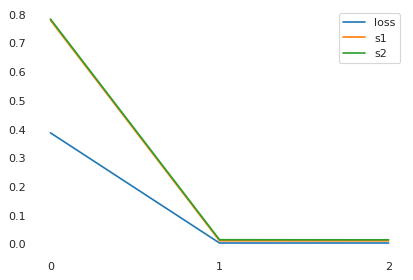

In [132]:
dpaModel_parabola.plot_energy_loss(X_parabola.to(device), xscale="linear")

In [ ]:
limits = ((X_parabola[:, 0].min() * 1.5, X_parabola[:, 0].max() * 1.5),
          (X_parabola[:, 1].min() * 1.5, X_parabola[:, 1].max() * 1.5),)
n_components = X_parabola.shape[1]
fig, axs = plt.subplots(1, n_components, figsize=(10 * n_components, 8))

if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(dpaeFunc_parabola, component=i, levels=25, ax=ax, limits=limits)
    plot_isolines_2D(dpaeFunc_parabola, component=i, mode='contour', levels=25, ax=ax, limits=limits)

    ax.scatter(X_parabola[:, 0], X_parabola[:, 1], s=1, c="k", alpha=0.5)

plt.show();

with torch.no_grad():
    z_lat_parabola = dpaModel_parabola.encode(X_parabola.to(device))
    X_prime_parabola = dpaModel_parabola.decode(z_lat_parabola.to(device),
                                                mean=False,
                                                gen_sample_size=1
                                                ).squeeze().cpu().numpy()
    U2_parabola = z_lat_parabola[:, 1].unsqueeze(-1).cpu().numpy()
    Z1_parabola = z_lat_parabola[:, 0].unsqueeze(-1).cpu().numpy()

In [ ]:
plt.plot(z_lat_parabola[:, 0].cpu().numpy(), z_lat_parabola[:, 1].cpu().numpy(), 'o', markersize=1, alpha=0.5);

## Numerical results

In [137]:
res = determinism_check(Z1_parabola, U2_parabola, model='spline', n_knots=25,
                        r2_threshold=0.999, maxerr_threshold=5e-2)
res

{'max_err': np.float32(0.0017285496),
 'mean_err': np.float32(0.0003614097),
 'R2': 0.9996746182441711,
 'passed': np.True_}

In [139]:
res = determinism_check(Z1_parabola, U2_parabola, model='rf', n_estimators=500, min_samples_leaf=2,
                        r2_threshold=0.999, maxerr_threshold=5e-2)
res

{'max_err': np.float64(0.004097511623303074),
 'mean_err': np.float64(0.0011627267062889047),
 'R2': 0.9965256752899714,
 'passed': False}

In [ ]:
res = determinism_check(Z1_parabola, U2_parabola, model='poly', degree=15,
                        r2_threshold=0.999, maxerr_threshold=5e-2)
res

In [ ]:

h_u_given_z = conditional_entropy(U2_parabola, Z1_parabola, k=5)
print("H(U|Z) ≈", h_u_given_z, "nats")

In [ ]:

dim_dict = intrinsic_dim_drop(Z1_parabola, U2_parabola, estimator="MLE",

                              )
print(dim_dict)


In [ ]:
percentiles_parabola, drops_parabola = bootstrap_dim_drop(
    Z1_parabola,
    U2_parabola,
    n_boot=200,
    k=15)

In [ ]:
percentiles_parabola

In [ ]:
joblib.dump(
    {
        "drops"      : drops_parabola,
        "percentiles": percentiles_parabola
    },
    f"{prefix}/bootstrap_dim_drop.pt"
)

# Exponential

In [150]:
X_exponential = torch.load("data/indep/exponential/data_10000_42.pt")

In [151]:
n_feats = 2
k = 2
num_layer = 4
hidden_dim = 100
latent_dims = list(range(k + 1))[::-1]

In [152]:
prefix = f"res/indep/exponential/{k}k{num_layer}l{hidden_dim}h/"

In [ ]:
dpaModel_exponential = DPA(beta=1.,
                           dist_enc="deterministic",
                           dist_dec="stochastic",
                           data_dim=n_feats,
                           latent_dims=latent_dims,
                           num_layer=num_layer,
                           hidden_dim=hidden_dim,
                           noise_dim=hidden_dim,
                           resblock=True,
                           standardize=False,
                           device=device,
                           seed=42
                           )


In [ ]:

a = extract_first_numbers_after_epoch(f"{prefix}/log.txt")
plt.plot(a[1:, 0], a[1:, 1])

argmin = np.argmin(a[1:, 1])
plt.axvline(a[argmin + 1, 0], c="r")
plt.axhline(0);
a[argmin + 1, 0], a[argmin + 1, 1]

dpaModel_exponential.model.load_state_dict(torch.load(f"{prefix}/model_{int(a[argmin + 1, 0])}.pt"))
dpaModel_exponential.model = dpaModel_exponential.model.to(device)
dpaModel_exponential.model.eval();
dpaeFunc_exponential = EncoderModule(dpaModel_exponential)


In [ ]:
dpaModel_exponential.plot_mse(X_exponential.to(device), xscale="linear")

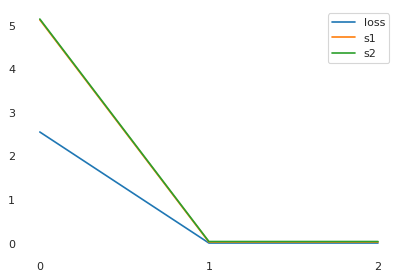

In [157]:
dpaModel_exponential.plot_energy_loss(X_exponential.to(device), xscale="linear")

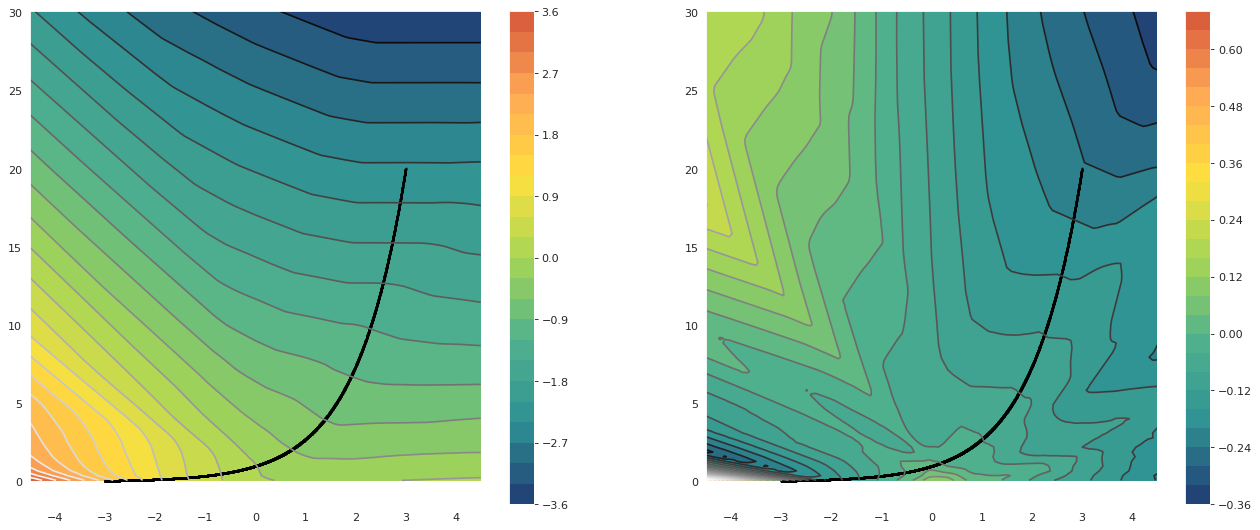

In [158]:
limits = ((X_exponential[:, 0].min() * 1.5, X_exponential[:, 0].max() * 1.5),
          (X_exponential[:, 1].min() * 1.5, X_exponential[:, 1].max() * 1.5),)
n_components = X_exponential.shape[1]
fig, axs = plt.subplots(1, n_components, figsize=(10 * n_components, 8))

if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(dpaeFunc_exponential, component=i, levels=25, ax=ax, limits=limits)
    plot_isolines_2D(dpaeFunc_exponential, component=i, mode='contour', levels=25, ax=ax, limits=limits)

    ax.scatter(X_exponential[:, 0], X_exponential[:, 1], s=1, c="k", alpha=0.5)

plt.show();

In [ ]:
with torch.no_grad():
    z_lat_exponential = dpaModel_exponential.encode(X_exponential.to(device))
    X_prime_exponential = dpaModel_exponential.decode(z_lat_exponential.to(device),
                                                      mean=False,
                                                      gen_sample_size=1
                                                      ).squeeze().cpu().numpy()
    U2_exponential = z_lat_exponential[:, 1].unsqueeze(-1).cpu().numpy()
    Z1_exponential = z_lat_exponential[:, 0].unsqueeze(-1).cpu().numpy()

plt.plot(z_lat_exponential[:, 0].cpu().numpy(), z_lat_exponential[:, 1].cpu().numpy(), 'o', markersize=1, alpha=0.5);

## Numerical results

In [173]:
res = determinism_check(Z1_exponential, U2_exponential, model='spline', n_knots=32,
                        r2_threshold=0.999, maxerr_threshold=5e-2)
res

{'max_err': np.float32(0.009131104),
 'mean_err': np.float32(0.00080106145),
 'R2': 0.9995642304420471,
 'passed': np.True_}

In [172]:
res = determinism_check(Z1_exponential, U2_exponential, model='rf', n_estimators=1000, min_samples_leaf=2,
                        r2_threshold=0.999, maxerr_threshold=5e-2)
res

{'max_err': np.float64(0.011540939411891812),
 'mean_err': np.float64(0.0026128777335300423),
 'R2': 0.996711246893676,
 'passed': False}

In [ ]:
res = determinism_check(Z1_exponential, U2_exponential, model='poly', degree=8,
                        r2_threshold=0.999, maxerr_threshold=5e-2)
res

In [ ]:

h_u_given_z = conditional_entropy(U2_exponential, Z1_exponential, k=5)
print("H(U|Z) ≈", h_u_given_z, "nats")

In [ ]:

dim_dict = intrinsic_dim_drop(Z1_exponential, U2_exponential, estimator="MLE",

                              )
print(dim_dict)


In [ ]:
percentiles_exponential, drops_exponential = bootstrap_dim_drop(
    Z1_exponential,
    U2_exponential,
    n_boot=200,
    k=15)
percentiles_exponential

In [ ]:
joblib.dump(
    {
        "drops"      : drops_exponential,
        "percentiles": percentiles_exponential
    },
    f"{prefix}/bootstrap_dim_drop.pt"
)

# Helix slice

In [174]:
X_helix_slice = torch.load("data/indep/helix_slice/data_10000_42.pt")

In [175]:
n_feats = 2
k = 2
num_layer = 4
hidden_dim = 100
latent_dims = list(range(k + 1))[::-1]

In [176]:
prefix = f"res/indep/helix_slice/{k}k{num_layer}l{hidden_dim}h/"

In [ ]:
dpaModel_helix_slice = DPA(beta=1.,
                           dist_enc="deterministic",
                           dist_dec="stochastic",
                           data_dim=n_feats,
                           latent_dims=latent_dims,
                           num_layer=num_layer,
                           hidden_dim=hidden_dim,
                           noise_dim=hidden_dim,
                           resblock=True,
                           standardize=False,
                           device=device,
                           seed=42
                           )


In [ ]:

a = extract_first_numbers_after_epoch(f"{prefix}/log.txt")
plt.plot(a[1:, 0], a[1:, 1])

argmin = np.argmin(a[1:, 1])
plt.axvline(a[argmin + 1, 0], c="r")
plt.axhline(0);
a[argmin + 1, 0], a[argmin + 1, 1]

In [ ]:
dpaModel_helix_slice.model.load_state_dict(torch.load(f"{prefix}/model_{int(a[argmin + 1, 0])}.pt"))
dpaModel_helix_slice.model = dpaModel_helix_slice.model.to(device)
dpaModel_helix_slice.model.eval();
dpaeFunc_helix_slice = EncoderModule(dpaModel_helix_slice)


In [ ]:
dpaModel_helix_slice.plot_mse(X_helix_slice.to(device), xscale="linear")

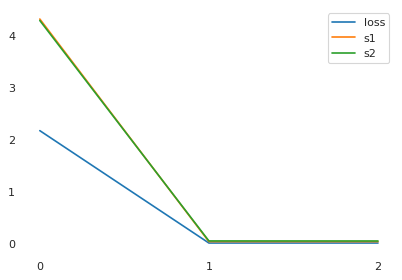

In [181]:
dpaModel_helix_slice.plot_energy_loss(X_helix_slice.to(device), xscale="linear")

In [ ]:
limits = ((X_helix_slice[:, 0].min() * 1.5, X_helix_slice[:, 0].max() * 1.5),
          (X_helix_slice[:, 1].min() * 1.5, X_helix_slice[:, 1].max() * 1.5),)
n_components = X_helix_slice.shape[1]
fig, axs = plt.subplots(1, n_components, figsize=(10 * n_components, 8))

if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(dpaeFunc_helix_slice, component=i, levels=25, ax=ax, limits=limits)
    plot_isolines_2D(dpaeFunc_helix_slice, component=i, mode='contour', levels=25, ax=ax, limits=limits)

    ax.scatter(X_helix_slice[:, 0], X_helix_slice[:, 1], s=1, c="k", alpha=0.5)

plt.show();

with torch.no_grad():
    z_lat_helix_slice = dpaModel_helix_slice.encode(X_helix_slice.to(device))
    X_prime_helix_slice = dpaModel_helix_slice.decode(z_lat_helix_slice.to(device),
                                                      mean=False,
                                                      gen_sample_size=1
                                                      ).squeeze().cpu().numpy()
    U2_helix_slice = z_lat_helix_slice[:, 1].unsqueeze(-1).cpu().numpy()
    Z1_helix_slice = z_lat_helix_slice[:, 0].unsqueeze(-1).cpu().numpy()

In [ ]:
plt.plot(z_lat_helix_slice[:, 0].cpu().numpy(), z_lat_helix_slice[:, 1].cpu().numpy(), 'o', markersize=1, alpha=0.5);

## Numerical results

In [185]:
res = determinism_check(Z1_helix_slice, U2_helix_slice, model='spline', n_knots=32,
                        r2_threshold=0.999, maxerr_threshold=5e-2)
res

{'max_err': np.float32(0.028814256),
 'mean_err': np.float32(0.0039503104),
 'R2': 0.9994865655899048,
 'passed': np.True_}

In [193]:
res = determinism_check(Z1_helix_slice, U2_helix_slice, model='rf', n_estimators=400, min_samples_leaf=2,
                        r2_threshold=0.999, maxerr_threshold=5e-2)
res

{'max_err': np.float64(0.8227137671014265),
 'mean_err': np.float64(0.19074342526301963),
 'R2': -0.07618672380263325,
 'passed': False}

In [ ]:
res = determinism_check(Z1_helix_slice, U2_helix_slice, model='poly', degree=8,
                        r2_threshold=0.999, maxerr_threshold=5e-2)
res

h_u_given_z = conditional_entropy(U2_helix_slice, Z1_helix_slice, k=5)
print("H(U|Z) ≈", h_u_given_z, "nats")

dim_dict = intrinsic_dim_drop(Z1_helix_slice, U2_helix_slice, estimator="MLE",

                              )
print(dim_dict)


In [ ]:
percentiles_helix_slice, drops_helix_slice = bootstrap_dim_drop(
    Z1_helix_slice,
    U2_helix_slice,
    n_boot=200,
    k=15)
percentiles_helix_slice

In [ ]:
joblib.dump(
    {
        "drops"      : drops_helix_slice,
        "percentiles": percentiles_helix_slice
    },
    f"{prefix}/bootstrap_dim_drop.pt"
)

# Grid sum

In [194]:
X_grid_sum = torch.load("data/indep/grid_sum/data_10000_42.pt")

In [195]:
X_grid_sum.shape

torch.Size([3600, 3])

In [196]:
n_feats = 3
k = 3
num_layer = 4
hidden_dim = 100
latent_dims = list(range(k + 1))[::-1]

In [197]:
prefix = f"res/indep/grid_sum/{k}k{num_layer}l{hidden_dim}h/"

In [ ]:
dpaModel_grid_sum = DPA(beta=1.,
                        dist_enc="deterministic",
                        dist_dec="stochastic",
                        data_dim=n_feats,
                        latent_dims=latent_dims,
                        num_layer=num_layer,
                        hidden_dim=hidden_dim,
                        noise_dim=hidden_dim,
                        resblock=True,
                        standardize=False,
                        device=device,
                        seed=42
                        )


In [ ]:

a = extract_first_numbers_after_epoch(f"{prefix}/log.txt")
plt.plot(a[1:, 0], a[1:, 1])

argmin = np.argmin(a[1:, 1])
plt.axvline(a[argmin + 1, 0], c="r")
plt.axhline(0);
a[argmin + 1, 0], a[argmin + 1, 1]

dpaModel_grid_sum.model.load_state_dict(torch.load(f"{prefix}/model_{int(a[argmin + 1, 0])}.pt"))
dpaModel_grid_sum.model = dpaModel_grid_sum.model.to(device)
dpaModel_grid_sum.model.eval();
dpaeFunc_grid_sum = EncoderModule(dpaModel_grid_sum)


In [ ]:
dpaModel_grid_sum.plot_mse(X_grid_sum.to(device), xscale="linear")

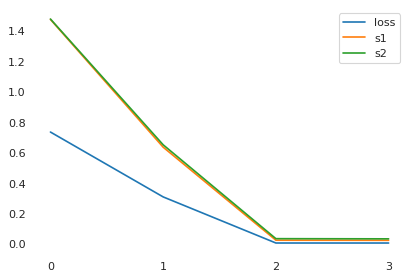

In [203]:
dpaModel_grid_sum.plot_energy_loss(X_grid_sum.to(device), xscale="linear")

In [ ]:
with torch.no_grad():
    z_lat_grid_sum = dpaModel_grid_sum.encode(X_grid_sum.to(device))
    X_prime_grid_sum = dpaModel_grid_sum.decode(z_lat_grid_sum.to(device),
                                                mean=False,
                                                gen_sample_size=1
                                                ).squeeze().cpu().numpy()
    U2_grid_sum = z_lat_grid_sum[:, 2:].cpu().numpy()
    Z1_grid_sum = z_lat_grid_sum[:, :2].cpu().numpy()

In [ ]:
plt.scatter(z_lat_grid_sum[:, 0].cpu().numpy(),
            z_lat_grid_sum[:, 2].cpu().numpy(),

            );

In [ ]:
plot_3d(z_lat_grid_sum.cpu().numpy())

## Numerical results

In [223]:
res = determinism_check(Z1_grid_sum, U2_grid_sum, model='spline', n_knots=64,
                        r2_threshold=0.999, maxerr_threshold=5e-2)
res

{'max_err': np.float32(0.34586316),
 'mean_err': np.float32(0.09877881),
 'R2': 0.9138873219490051,
 'passed': False}

In [224]:
res = determinism_check(Z1_grid_sum, U2_grid_sum, model='rf', n_estimators=1000, min_samples_leaf=2,
                        r2_threshold=0.999, maxerr_threshold=5e-2)
res

{'max_err': np.float64(0.08232153701399036),
 'mean_err': np.float64(0.020199718202701434),
 'R2': 0.9963564505435076,
 'passed': False}

In [229]:
res = determinism_check(Z1_grid_sum, U2_grid_sum, model='poly', degree=7,
                        r2_threshold=0.999, maxerr_threshold=5e-2)
res

{'max_err': np.float32(0.08691144),
 'mean_err': np.float32(0.012420985),
 'R2': 0.998581051826477,
 'passed': False}

In [ ]:

h_u_given_z = conditional_entropy(U2_grid_sum, Z1_grid_sum, k=5)
print("H(U|Z) ≈", h_u_given_z, "nats")

In [ ]:

dim_dict = intrinsic_dim_drop(Z1_grid_sum, U2_grid_sum, estimator="MLE",

                              )
print(dim_dict)


In [ ]:
percentiles_grid_sum, drops_grid_sum = bootstrap_dim_drop(
    Z1_grid_sum,
    U2_grid_sum,
    n_boot=200,
    k=15)
percentiles_grid_sum

In [ ]:
joblib.dump(
    {
        "drops"      : drops_grid_sum,
        "percentiles": percentiles_grid_sum
    },
    f"{prefix}/bootstrap_dim_drop.pt"
)